In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment

In [2]:
def mmss_to_sec(mmss):
    """
    convet the time (mm:ss) to second
    
    Args:
        mmss (int): the time (mm:ss)

    Returns:
        sec (int): second
    """
    
    mmss = str(mmss).zfill(4)
    
    minute = int(str(mmss)[:2])
    second = int(str(mmss)[2:])
    
    sec = minute * 60 + second
    
    return sec

In [3]:
def scale_pos(pos):
    """
    min-max scale the coordinates
    x: 0.0~1.0
    y: 0.0~0.7

    Args:
        pos (np.ndarray, shape (10, 2)): the coordinates of the field players

    Returns:
        pos_scaled (np.ndarray, shape (10, 2)): the scaled coordinates of the field players
    """
    
    x_scaler = MinMaxScaler(feature_range=(0.0, 1.0))
    y_scaler = MinMaxScaler(feature_range=(0.0, 0.7))
    
    x_scaled = x_scaler.fit_transform(pos.T[0].reshape(-1, 1))
    y_scaled = y_scaler.fit_transform(pos.T[1].reshape(-1, 1))
    
    pos_scaled = np.hstack((x_scaled, y_scaled))
    
    return pos_scaled

In [4]:
def standardize_pos(pos):
    """
    normalize the coordinates

    Args:
        pos (np.ndarray, shape (10, 2)): the coordinates of the field players

    Returns:
        pos_std (np.ndarray, shape (10, 2)): the standardized coordinates of the field players
    """
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    x_std = x_scaler.fit_transform(pos.T[0].reshape(-1, 1))
    y_std = y_scaler.fit_transform(pos.T[1].reshape(-1, 1))
    
    pos_std = np.hstack((x_std, y_std))
    
    return pos_std

In [5]:
def load_dataset(start, end):
    """
    1. load dataset and pre-processing
    2. make the list of player id
    
    Args:
        start (float) : the start time of the part (mm:ss)
        end (float) : the end time of the part (mm:ss)
        
    Returns:
        pos (np.ndarray, shape (sample_num, 10, 2)) : the coordinates of the field players after pre-processing
        numbers (list) : the list of player id
    """
    
    # read the dataset and set the index
    data = pd.read_csv('../data/input/processed/prepped_tromso_stromsgodset_first.csv')
    
    # start and end time of the segment
    start = mmss_to_sec(start)
    end = mmss_to_sec(end)

    # extract data of the segment
    data = data[(start<=data['timestamp']) & (data['timestamp']<=end)]

    # the coordinates of the field players
    player_ids = data['tag_id'].unique()
    frame_num = len(data) // 10
    pos = np.zeros((frame_num, 10, 2))
    for i, player_id in enumerate(player_ids):
        pos[:, i] = data[data['tag_id']==player_id][['x_pos', 'y_pos']].values

    # standardize the position of all players in each frame
    for f in range(frame_num):
        pos[f] = standardize_pos(pos[f])
        
    return pos, player_ids

In [6]:
def compute_form_summary(pos):
    """
    1. compute the mean coordinates of 10 roles
    2. create the role assignment matrix
    
    Args:
        pos (np.ndarray): the coordinates of the field players after pre-processing
    
    Returns:
        form_summary (np.ndarray): the mean coordinates of each role
        assign_mat (np.ndarray): the role assignment matrix
    """
    
    pos_role = pos.copy()
    
    # Bialkowski's method
    # https://ieeexplore.ieee.org/document/7492601
    for i in range(2): # one iteration is enough
        # compute a multivariate normal random variable for each role
        rvs = []
        for role in range(10):
            mean = [np.mean(pos_role[:, role, 0]), np.mean(pos_role[:, role, 1])]
            cov = np.cov(pos_role[:, role, 0], pos_role[:, role, 1])
            rvs.append(multivariate_normal(mean, cov))
            
        # formulate a cost matrix based on the log probability of each position
        # assign the labels to the players using the cost matrix
        assign_mat = np.zeros((10, 10))
        for f in range(len(pos)):
            cost_mat = np.zeros((10, 10))
            for role in range(10):
                cost_mat[role] = rvs[role].logpdf(pos_role[f])
                
            # exucute the Hungarian method to assign the role label to each player
            row_ind, col_ind = linear_sum_assignment(-cost_mat)
            pos_role[f] = pos_role[f, col_ind]
            # add counts the role assignment matrix
            for row, col in zip(row_ind, col_ind):
                assign_mat[row, col] += 1
                
        # compute the coordinates of 10 roles
        form_summary = np.mean(pos_role, axis=0)
        
        # min-max scaling
        # x: 0.0~1.0
        # y: 0.0~0.7
        form_summary = scale_pos(form_summary)
        
        return form_summary, assign_mat

In [7]:
def compute_similarity(form1, form2):
    """
    compute the similarity between two formations
    
    Args:
        form 1 (np.ndarray, shape (10, 2)): the coordinate of 10 players
        form 2 (np.ndarray, shape (10, 2))
    
    Returns:
        similarity (float); the similarity between form1 and form2
    """
    
    # min-max scaling
    # x: 0.0~1.0
    #  y: 0.0~0.7
    form1 = scale_pos(form1)
    form2 = scale_pos(form2)
    
    # create the similarity matrix
    sim_mat = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            norm = np.linalg.norm(form1[i] - form2[j], 2) # L2 norm
            m = 1 - ((norm**2) / (1/3))
            sim_mat[i, j] = np.max([m, 0])
            
    # comute the similarity via the Hungarian method
    row_ind, col_ind = linear_sum_assignment(-sim_mat)
    similarity = sim_mat[row_ind, col_ind].sum() / 10
    
    return similarity, col_ind

In [8]:
def visualize_form_summary(form_summary, assign_mat, player_ids):
    """
    1. visualize the formation summary
    2. show the role assignment matrix
    3. suggest several formations similar to the formation summary
    
    Args:
        form_summary (np.ndarray, shape (10, 2)): the mean coordinates of each role
        assign_mat (np.ndarray, shape (10, 10)): the role assignment matrix
        player_ids (list): the list of the id of 10 field players
    """
    
    # load the data of the formation templetes
    forms, form_labels, forwards, DF = load_formations()
    
    # compute the similarities between the formation summary and each formation templet
    sims = []
    assigns = []
    for form in forms:
        sim, assign = compute_similarity(form_summary, form)
        sims.append(sim)
        assigns.append(assign)
        
    # sort the index by the similarity
    rank_idx = np.argsort(sims)[::-1]
    
    # create the list of assigned roles
    roles = [forms[rank_idx[0]][role][2] for role in assigns[rank_idx[0]]]
    
    # visualize the formation summary
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    plt.subplots_adjust(wspace=.3, hspace=.3)
    
    axes[0].set_title("Visual Formation Summary")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    axes[0].set_xlim(-0.8, 1.2)
    axes[0].set_ylim(-0.2, 0.9)
    axes[0].plot([-0.1, -0.1], [-0.1, 0.8], color="black", linewidth=.1)
    axes[0].plot([1.1, 1.1], [-0.1, 0.8], color="black", linewidth=.1)
    axes[0].plot([-0.1, 1.1], [-0.1, -0.1], color="black", linewidth=.1)
    axes[0].plot([-0.1, 1.1], [0.8, 0.8], color="black", linewidth=.1)
    for i, role in enumerate(roles):
        if np.isin(role, forwards):
            axes[0].scatter(form_summary[i, 0], form_summary[i, 1], color="red")
        elif np.isin(role, DF):
            axes[0].scatter(form_summary[i, 0], form_summary[i, 1], color="blue")
        else:
            axes[0].scatter(form_summary[i, 0], form_summary[i, 1], color="green")
            
    # annotate the role labels
    for role, (x, y) in enumerate(form_summary):
        axes[0].annotate(roles[role], (x+.03, y*.03))
        
    # show the similarity toward top 5 formation
    for i in range(5):
        axes[0].text(-0.7, 0.5-i*0.1, "{}. {} - Similarity: {:.3f}".format(i+1, form_labels[rank_idx[i]], sims[rank_idx[i]]))
        
    # show the role assignment matrix
    sns.heatmap(assign_mat,
                fmt='1.0f',
                cmap="Greens",
                annot=True,
                cbar=False,
                xticklabels=player_ids,
                yticklabels=roles
               )

    axes[1].set_title("Role assignments")
    axes[1].set_xlabel("Player")
    axes[1].set_ylabel("Role")
    axes[1].tick_params(axis='x', rotation=45)

    plt.show()

In [9]:
import numpy as np

def load_formations():
    """
    Returns:
        forms (list, shape (25, 10, 3)): the 2d array of positional data of position names for 25 templete formations 
        form_labels (list): the list of the names of 25 templete formations
        forwards (list): the list of the names of offensive roles
        defenders (list): the lsit of the names of defensive roles
    """

    # define the formations
    f_343 = np.array([[2, 3, 'RCB'], [2, 5, 'CB'], [2, 7, 'LCB'], [5, 2, 'RM'], [5, 4, 'RCM'], [5, 6, 'LCM'], [5, 8, 'LM'], [7, 2, 'RW'], [7, 8, 'LW'], [8, 5, 'ST']])

    f_352 = np.array([[2, 3, 'RCB'], [2, 5, 'CB'], [2, 7, 'LCB'], [4, 4, 'RCDM'], [4, 6, 'LCDM'],  [6, 2, 'RM'], [6, 5, 'CAM'], [6, 8, 'LM'], [8, 4, 'RST'], [8, 6, 'LST']])

    f_41212 = np.array([[3, 2, 'RB'], [2, 4, 'RCB'], [2, 6, 'LCB'], [3, 8, 'LB'], [4, 5, 'CDM'],  [5, 3, 'RCM'], [5, 7, 'LCM'], [6, 5, 'CAM'], [8, 4, 'RST'], [8, 6, 'LST']])

    f_4231 = np.array([[3, 2, 'RB'], [2, 4, 'RCB'], [2, 6, 'LCB'], [3, 8, 'LB'], [4, 4, 'RCDM'],  [4, 6, 'LCDM'], [6, 2, 'RM'], [6, 8, 'LM'], [6, 5, 'CAM'], [8, 5, 'ST']])

    f_442 = np.array([[3, 2, 'RB'], [2, 4, 'RCB'], [2, 6, 'LCB'], [3, 8, 'LB'], [6, 2, 'RM'],  [5, 4, 'RCM'], [5, 6, 'LCM'], [6, 8, 'LM'], [8, 4, 'RST'], [8, 6, 'LST']])

    f_4123 = np.array([[3, 2, 'RB'], [2, 4, 'RCB'], [2, 6, 'LCB'], [3, 8, 'LB'], [4, 5, 'CDM'],  [5, 3, 'RCM'], [5, 7, 'LCM'], [7, 2, 'RW'], [7, 8, 'LW'], [8, 5, 'ST']])

    f_4213 = np.array([[3, 2, 'RB'], [2, 4, 'RCB'], [2, 6, 'LCB'], [3, 8, 'LB'], [4, 4, 'RCDM'],  [4, 6, 'LCDM'], [6, 5, 'CAM'], [7, 2, 'RW'], [7, 8, 'LW'], [8, 5, 'ST']])

    f_541 = np.array([[2, 3, 'RCB'], [2, 5, 'CB'], [2, 7, 'LCB'], [3, 1, 'RWB'], [3, 9, 'LWB'], [5, 4, 'RCM'], [5, 6, 'LCM'], [7, 2, 'RW'], [7, 8, 'LW'], [8, 5, 'ST']])

    f_532 = np.array([[2, 3, 'RCB'], [2, 5, 'CB'], [2, 7, 'LCB'], [3, 1, 'RWB'], [3, 9, 'LWB'], [5, 2, 'RCM'], [5, 5, 'CM'], [5, 8, 'LCM'], [8, 4, 'RST'], [8, 6, 'LST']])

    forms = [f_343, f_352,
             f_41212, f_4231, f_442, f_4123, f_4213,
             f_541, f_532
             ]

    form_labels = ["343", "352",
               "41212", "4231", "442", "4213", "4123",
               "541", "532"
               ]

    forwards = ['ST', 'RST', 'LST', 
                'LW', 'RW']
        
    defenders = ['CB', 'LCB', 'RCB', 
                 'LB', 'RB',
                 'LWB', 'RWB']

    return forms, form_labels, forwards, defenders

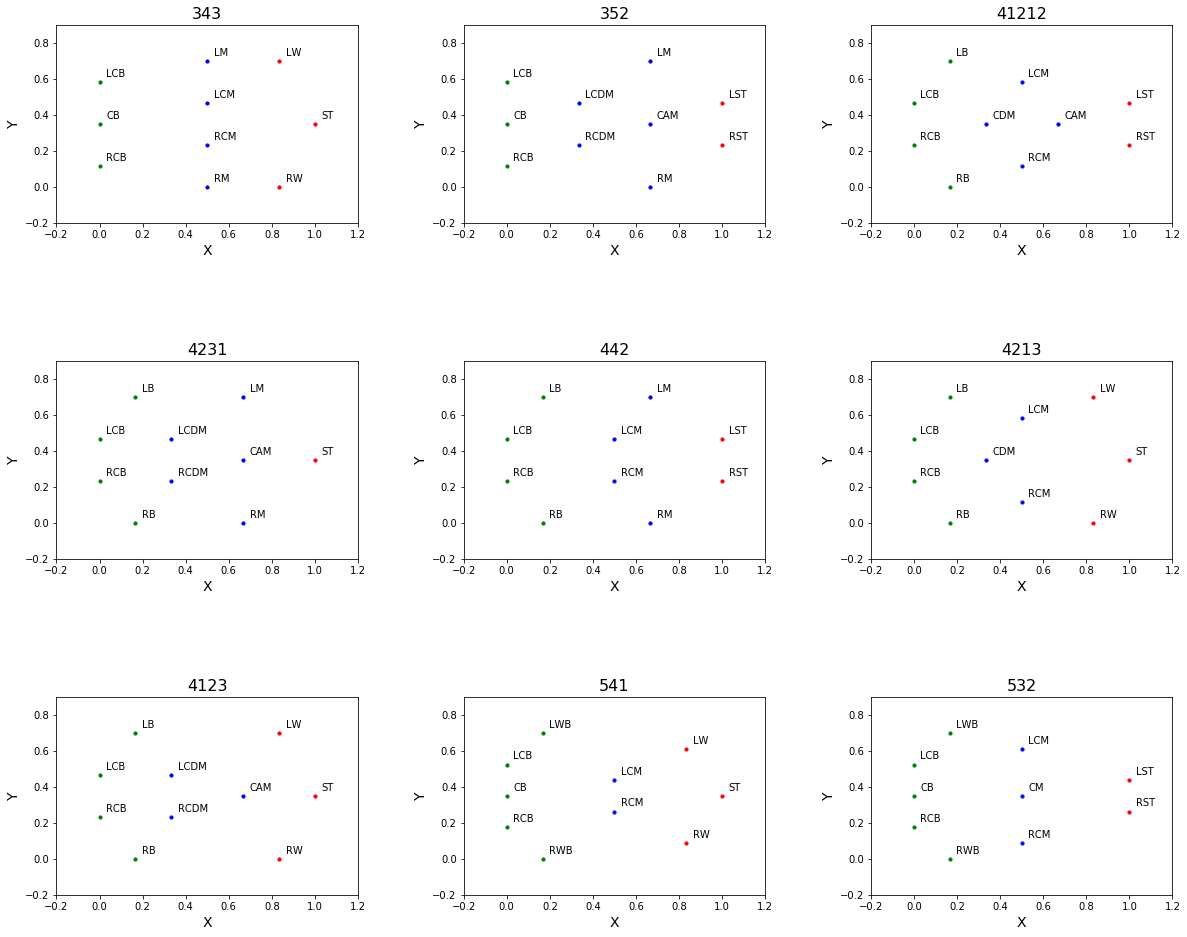

In [11]:
forms, form_labels, forwards, defenders = load_formations()

plt.figure(figsize=(20, 16))
plt.subplots_adjust(wspace=0.35, hspace=0.7)

for i in range(len(forms)):
    
    normed_form = scale_pos(forms[i])
    
    plt.subplot(3, 3, i+1)
    
    plt.title(form_labels[i], size=16)
    
    plt.xlabel("X", size=14)
    plt.ylabel("Y", size=14)
    plt.xlim(-0.2, 1.2)
    plt.ylim(-0.2, 0.9)
    
    for n in range(10):
        if np.isin(forms[i][n][2], forwards):
            plt.scatter(normed_form[n][0], normed_form[n][1], color="red", s=10)
        elif np.isin(forms[i][n][2], defenders):
            plt.scatter(normed_form[n][0], normed_form[n][1], color="green", s=10)
        else:
            plt.scatter(normed_form[n][0], normed_form[n][1], color="blue", s=10)
            
    for n, (x, y) in enumerate(zip(normed_form[:, 0], normed_form[:, 1])):
        plt.annotate(forms[i][n][2], (x+.03, y+.03))

plt.show()

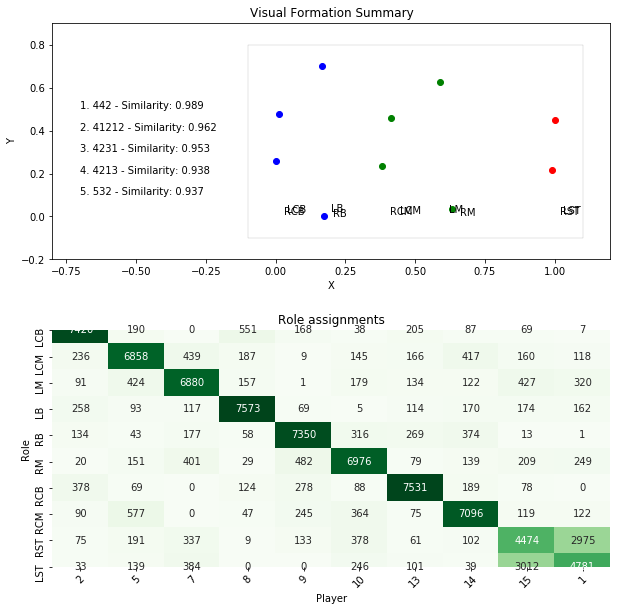

In [17]:
pos, player_ids = load_dataset(0, 4500)

form_summary, assign_mat = compute_form_summary(pos)

visualize_form_summary(form_summary, assign_mat, player_ids)